In [1]:
#NOTE: use paimg9 env
import sys
import os
import numpy as np
import openslide
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import pandas as pd
import warnings
import torch
import torch.nn as nn

from sklearn.model_selection import KFold, train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader
import torch.optim as optim
from pathlib import Path
import PIL
from skimage import filters
import random

    
sys.path.insert(0, '../Utils/')
from Utils import create_dir_if_not_exists
from Utils import generate_deepzoom_tiles, extract_tile_start_end_coords, get_map_startend
from Utils import get_downsample_factor
from Utils import minmax_normalize, set_seed
from Utils import log_message
from Eval import compute_performance, plot_LOSS, compute_performance_each_label, get_attention_and_tileinfo
from train_utils import pull_tiles
from train_utils import ModelReadyData_diffdim_withclusterinfo, convert_to_dict, prediction, BCE_Weighted_Reg, compute_loss_for_all_labels
from Model import Mutation_MIL_MT
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
####################################
######      USERINPUT       ########
####################################
SELECTED_MUTATION = "MT"
model_name = "MIL" #Chose from Linear, LinearMT
#SELECTED_LABEL = ["AR","MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2","PTEN","RB1","TP53","TMB_HIGHorINTERMEDITATE","MSI_POS"]
SELECTED_LABEL = ["AR","HR","PTEN","RB1","TP53","TMB_HIGHorINTERM","MSI_POS"]
#SELECTED_FEATURE = [str(i) for i in range(0,2048)] + ['TUMOR_PIXEL_PERC']
SELECTED_FEATURE = [str(i) for i in range(0,2048)]
TUMOR_FRAC_THRES = 0
TRAIN_SAMPLE_SIZE = "ALL_TUMOR_TILES"
TRAIN_OVERLAP = 100
TEST_OVERLAP = 0


##################
###### DIR  ######
##################
proj_dir = '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/'
wsi_path = proj_dir + '/data/OPX/'
label_path = proj_dir + 'data/MutationCalls/'
model_path = proj_dir + 'models/feature_extraction_models/'
ft_ids_path =  proj_dir + 'intermediate_data/cd_finetune/cancer_detection_training/' #the ID used for fine-tuning cancer detection model, needs to be excluded from mutation study
train_tile_path = proj_dir + 'intermediate_data/cancer_prediction_results110224/IMSIZE250_OL' + str(TRAIN_OVERLAP) + '/'
test_tile_path =  proj_dir + 'intermediate_data/cancer_prediction_results110224/IMSIZE250_OL' + str(TEST_OVERLAP) + '/'
model_data_path =  proj_dir + 'intermediate_data/model_ready_data/' + 'MAX_SS'+ str(TRAIN_SAMPLE_SIZE) + '_NFEATURES' + str(len(SELECTED_FEATURE)) + '_TrainOL' + str(TRAIN_OVERLAP) +  '_TestOL' + str(TEST_OVERLAP) + '/'
feature_name = 'features_alltiles_retccl'

##################
#Select GPU
##################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
################################################
#Create output-dir
################################################
outdir0 =  proj_dir + "intermediate_data/pred_out/" + 'MAX_SS'+ str(TRAIN_SAMPLE_SIZE) + '_NFEATURES' + str(len(SELECTED_FEATURE)) + '_TrainOL' + str(TRAIN_OVERLAP) +  '_TestOL' + str(TEST_OVERLAP) + '/'
outdir1 =  outdir0  + SELECTED_MUTATION + "/clusters/" 
outdir2 =  proj_dir + 'intermediate_data/model_ready_data/' +'MAX_SS'+ str(TRAIN_SAMPLE_SIZE) + '_NFEATURES' + str(len(SELECTED_FEATURE)) + '_TrainOL' + str(TRAIN_OVERLAP) +  '_TestOL' + str(TEST_OVERLAP) + 'withCluster' + '/'


create_dir_if_not_exists(outdir0)
create_dir_if_not_exists(outdir1)
create_dir_if_not_exists(outdir2)

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/MAX_SSALL_TUMOR_TILES_NFEATURES2048_TrainOL100_TestOL0/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/MAX_SSALL_TUMOR_TILES_NFEATURES2048_TrainOL100_TestOL0/MT/clusters/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/model_ready_data/MAX_SSALL_TUMOR_TILES_NFEATURES2048_TrainOL100_TestOL0withCluster/' already exists.


In [4]:
################################################
#     Model ready data 
################################################
train_data = torch.load(model_data_path + 'train_data.pth')
test_data = torch.load(model_data_path + 'test_data.pth')
val_data = torch.load(model_data_path + 'val_data.pth')

train_ids = torch.load(model_data_path + 'train_ids.pth')
test_ids = torch.load(model_data_path + 'test_ids.pth')
val_ids = torch.load(model_data_path + 'val_ids.pth')

train_info  = torch.load(model_data_path + 'train_info.pth')
test_info  = torch.load(model_data_path + 'test_info.pth')
val_info  = torch.load(model_data_path + 'val_info.pth')

train_tf_info  = torch.load(model_data_path + 'train_tf_info.pth')
test_tf_info  = torch.load(model_data_path + 'test_tf_info.pth')
val_tf_info  = torch.load(model_data_path + 'val_tf_info.pth')

In [5]:
################################################
# Get clustering data
################################################
def get_cluster_data(indata, id_list, selected_labels):
    feature_list = [pd.DataFrame(x.numpy()) for x in indata.x]
    label_list = [y.squeeze().numpy() for y in indata.y]
    
    for i,x in enumerate(feature_list):
        x['ID'] = id_list[i]
        for j,l in enumerate(selected_labels):
            x[l] = int(label_list[i][j])
    feature_df = pd.concat(feature_list)
    return feature_df


train_feature_df = get_cluster_data(train_data, train_ids, SELECTED_LABEL)
test_feature_df = get_cluster_data(test_data, test_ids, SELECTED_LABEL)
valid_feature_df = get_cluster_data(val_data, val_ids, SELECTED_LABEL)

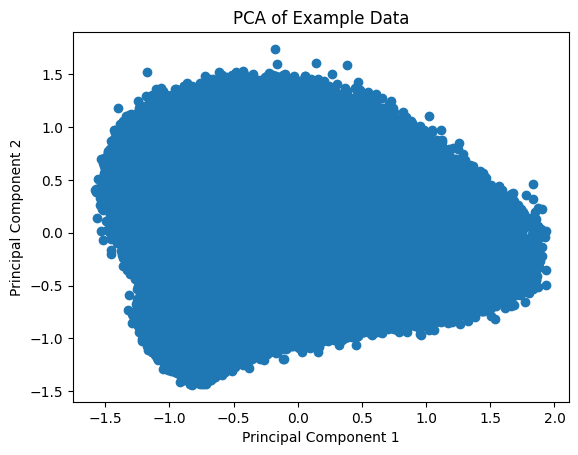

In [6]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(train_feature_df[range(0,2048)])

# Plot the principal components
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Example Data')
plt.show()

1
2
3
4
5
6
7
8
9
10


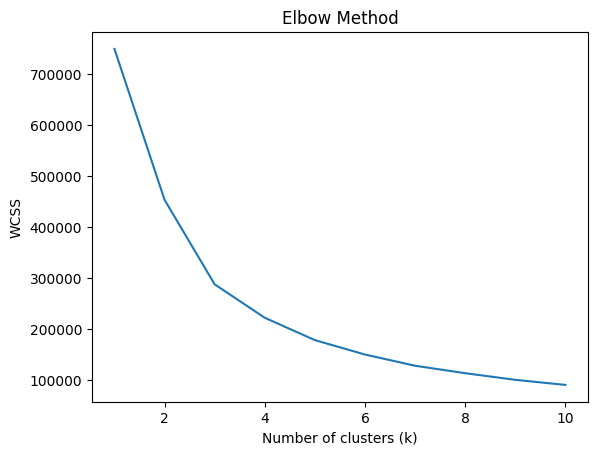

In [7]:
# Calculate WCSS for different values of k
wcss = []
for i in range(1, 11):
    print(i)
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(principal_components)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [8]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(principal_components)

# Get cluster centers and labels
centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Plot the data points and cluster centers with cluster labels
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis',alpha=0.6)
for i, center in enumerate(centers):
    plt.scatter(center[0], center[1], c='red', marker=f'${i}$', s=200)  # Use cluster label as marker

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering for Tile Embeddings on PCs')
plt.grid(True)
plt.savefig(outdir1  + 'original_cluster_scatter.png')
plt.close()

In [9]:
def get_cluster_label(feature_df, cluster_centers, cluster_features):
    r'''
    Get Cluster label by compute dist between test/valid pcs to the center of kmeans
    '''
    pcs = pca.fit_transform(feature_df[cluster_features])
    distances = np.linalg.norm(cluster_centers[:, np.newaxis] - pcs, axis=2)
    closest_indices = np.argmin(distances, axis=0)
    cluster_labels  = closest_indices

    return cluster_labels

cluster_labels_test = get_cluster_label(test_feature_df, centers, feature_for_cluster)
cluster_labels_val = get_cluster_label(valid_feature_df, centers, feature_for_cluster)

In [10]:
def get_feature_label_list(indata):
    feature_list = [x.numpy() for x in indata.x]
    label_list = [y.numpy() for y in indata.y]
    tf_list = [tf.numpy() for tf in indata.tf]

    return feature_list, label_list, tf_list

train_feature,train_label, train_tf_info = get_feature_label_list(train_data)
test_feature,test_label, test_tf_info = get_feature_label_list(test_data)
val_feature,val_label, val_tf_info = get_feature_label_list(val_data)

In [11]:
################################################
#     Model ready data 
################################################
updated_train_data = ModelReadyData_diffdim(train_feature,train_label,train_tf_info,labels)
updated_test_data = ModelReadyData_diffdim(test_feature,test_label,test_tf_info,cluster_labels_test)
updated_val_data = ModelReadyData_diffdim(val_feature,val_label,val_tf_info,cluster_labels_val)


#Output
torch.save(updated_train_data, outdir2 + 'train_data.pth')
torch.save(updated_test_data,  outdir2 + 'test_data.pth')
torch.save(updated_val_data,   outdir2 + 'val_data.pth')

torch.save(train_info,   outdir2 + 'train_info.pth')
torch.save(test_info,   outdir2 + 'test_info.pth')
torch.save(val_info,   outdir2 + 'val_info.pth')

torch.save(train_tf_info,   outdir2 + 'train_tf_info.pth')
torch.save(test_tf_info,   outdir2 + 'test_tf_info.pth')
torch.save(val_tf_info,   outdir2 + 'val_tf_info.pth')


torch.save(train_ids,   outdir2 + 'train_ids.pth')
torch.save(test_ids,   outdir2 + 'test_ids.pth')
torch.save(val_ids,   outdir2 + 'val_ids.pth')

In [12]:
#Assign cluster
train_feature_df['PC1'] = principal_components[:, 0]
train_feature_df['PC2'] = principal_components[:, 1]
train_feature_df['CLUSTER'] = labels

In [13]:
#Plot scatter cluster plot for each outcome,
for plot_outcome in SELECTED_LABEL:
    plot_data = train_feature_df[['PC1','PC2', 'CLUSTER'] + [plot_outcome]]
        
    # Create scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Separate dots by CLUSTER but color by Outcome
    for cluster in plot_data['CLUSTER'].unique():
        subset = plot_data[plot_data['CLUSTER'] == cluster]
        ax.scatter(subset['PC1'], subset['PC2'], 
                   s=np.where(subset[plot_outcome] == 1, 20, 0.001), 
                   c=['steelblue' if outcome == 0 else 'darkred' for outcome in subset[plot_outcome]], 
                   alpha=0.6,
                   linewidth=1.5, label=f'Cluster {cluster}',
                   zorder=3 if (subset[plot_outcome] == 1).any() else 2)
    
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(plot_outcome)
    plt.grid(True)
    plt.savefig(outdir1 +  'cluster_scatter_' + plot_outcome + '.png')
    plt.close()

In [14]:
# Plot distribution of outcome by cluster (stacked bar plot)   
for plot_outcome in SELECTED_LABEL:
    plot_data = train_feature_df[['PC1','PC2', 'CLUSTER'] + [plot_outcome]]
 
    # Create a crosstab to count the occurrences of each outcome per cluster
    crosstab = pd.crosstab(plot_data['CLUSTER'], plot_data[plot_outcome])
    
    # Calculate the percentage of each outcome per cluster
    percentage_crosstab = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
    
    # Plot the stacked bar chart
    percentage_crosstab.plot(kind='bar', stacked=True, color=['steelblue', 'darkred'])
    plt.xlabel(plot_outcome)
    plt.ylabel('Percentage')
    plt.title('Bar Chart of ' + plot_outcome + ' per Cluster')
    plt.legend(title=plot_outcome, loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    plt.tight_layout()
    plt.savefig(outdir1 + "outcome_distribution_" + plot_outcome + '.png')
    plt.close()

In [15]:
# Plot combined distribution of outcome by cluster 
for plot_outcome in SELECTED_LABEL:
    plot_data = train_feature_df[['PC1','PC2', 'CLUSTER'] + [plot_outcome]]

    # Create a crosstab to count the occurrences of each outcome per cluster
    crosstab = pd.crosstab(plot_data[plot_outcome],plot_data['CLUSTER'])

    # Calculate the percentage of each outcome per cluster
    percentage_crosstab = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
    
    # Plot the stacked bar chart
    percentage_crosstab.plot(kind='bar', stacked=False, color=['#440154','#3b528b','#5ec962','#fde725'])
    plt.xlabel(plot_outcome)
    plt.ylabel('Percentage')
    plt.title('Bar Chart of Clusters Per Outcome')
    plt.legend(title='Cluster', loc='center left', bbox_to_anchor=(1.0, 0.5))

    plt.tight_layout()
    plt.savefig(outdir1  + 'cluster_distribution_' +  plot_outcome + '.png')
    plt.close()